# **고급 Feacture 엔지니어링**
## **1 Gensim 을 활용한 NLP 알고리즘**
Word2Vec
1. ! pip install gensim

In [1]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load('../backup/model.bin')
w2v_model.wv.most_similar(positive=['woman','king'], negative=['man'])

[('chryses', 0.6371129751205444),
 ('priest', 0.6282371282577515),
 ('nymph', 0.6165897250175476),
 ('thanks', 0.6120550632476807),
 ('dishonored', 0.6062030792236328),
 ('narrate', 0.605045735836029),
 ('angered', 0.6038438677787781),
 ('chieftains', 0.6015218496322632),
 ('appease', 0.6003137826919556),
 ('akhilleus', 0.6002722978591919)]

In [2]:
w2v_model.wv.similarity('woman','man')

0.3998656

In [3]:
# sorted(w2v_model.wv.vocab.keys(), reverse=False)[:14]
len(w2v_model.wv.vocab.keys())

11098

## **2 Gensim 을 활용한 유사도 분석실습**
Word2Vec
1. ! pip install gensim
1. **"Ice"** 와 **"Fire"** 의 문학내 유사도 측정

In [4]:
w2v_model.wv.most_similar('stark')

[('principals', 0.9933313131332397),
 ('threatening', 0.9859204292297363),
 ('distorting', 0.9620187878608704),
 ('freeport', 0.9174789190292358),
 ('stood', 0.8492887616157532),
 ('extend', 0.8167773485183716),
 ('douglas', 0.767949104309082),
 ('1858', 0.7635020017623901),
 ('conspiracy', 0.762062668800354),
 ('values', 0.7606658339500427)]

<br></br>
# **The Simpson 대본의 학습 및 분석**
심슨 에피소드의 대본을 활용한 문장내 단어의 의미 분석 Totorial 입니다.
1. **[Kaggle Tutorial](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial)**
1. **[Simpson Script](https://www.kaggle.com/pierremegret/dialogue-lines-of-the-simpsons)**

In [5]:
import logging
import pandas as pd
from time import time

# Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", 
                    datefmt= '%H:%M:%S', level=logging.INFO)

## **1 PreProcessing**
데이터 전처리 작업의 진행

In [6]:
df = pd.read_csv('../backup/simpsons_dataset.csv')
print(df.shape)

# NaN, Null 데이터를 제거 합니다
print(df.isnull().sum())
df = df.dropna().reset_index(drop=True)
print(df.shape)
print(df.isnull().sum())
df.head(3)

(158314, 2)
raw_character_text    17814
spoken_words          26459
dtype: int64
(131853, 2)
raw_character_text    0
spoken_words          0
dtype: int64


raw_character_text                                       spoken_words
0        Miss Hoover  No, actually, it was a little of both. Sometim...
1       Lisa Simpson                             Where's Mr. Bergstrom?
2        Miss Hoover  I don't know. Although I'd sure like to talk t...

In [7]:
import re, spacy
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:  # 2글자 이상 단어만 선별
        return ' '.join(txt)
    
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() 
                  for row in df['spoken_words'])

# Spacy의 PipeLine 을 활용하여 표제어로 변경 및 Stopword 를 제거 합니다.
from tqdm import tqdm
nlp = spacy.load('en', disable=['ner', 'parser'])  # stopword 필터링 파이프라인
txt = [cleaning(doc) for doc in tqdm(nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1))]

# 데이터 없는 행제거 및 전처리 완료 된 테이블을 출력 합니다
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
df.head(3)

131853it [01:07, 1961.82it/s]

(85960, 1)


raw_character_text                                       spoken_words
0        Miss Hoover  No, actually, it was a little of both. Sometim...
1       Lisa Simpson                             Where's Mr. Bergstrom?
2        Miss Hoover  I don't know. Although I'd sure like to talk t...

In [8]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
df_clean.head(3)

(85960, 1)


clean
0  actually little disease magazine news show nat...
2        know sure like talk touch lesson plan teach
3                                    life worth live

## **2 N-Gram Modeling**
**"mr_burns", "bart_simpson"** 과 같은 **bi-gram** 모델을 만듭니다.

In [9]:
sent    = [row.split() for row in df_clean['clean']]
sent[:3]

[['actually',
  'little',
  'disease',
  'magazine',
  'news',
  'show',
  'natural',
  'think'],
 ['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach'],
 ['life', 'worth', 'live']]

In [10]:
# Phrases() 모듈에는 list로 구성된 텍스트를 바로 입력 가능 합니다
# Phraser() 를 사용하는 이유는 Phrases() 의 메모리 차지를 줄입니다

from gensim.models.phrases import Phrases, Phraser
phrases   = Phrases(sent, min_count=30, progress_per=10000)
bigram    = Phraser(phrases)
sentences = bigram[sent]
sentences

INFO - 15:35:52: collecting all words and their counts
INFO - 15:35:52: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:35:52: PROGRESS: at sentence #10000, processed 63561 words and 52716 word types
INFO - 15:35:52: PROGRESS: at sentence #20000, processed 130949 words and 99637 word types
INFO - 15:35:52: PROGRESS: at sentence #30000, processed 192972 words and 138212 word types
INFO - 15:35:52: PROGRESS: at sentence #40000, processed 249845 words and 172230 word types
INFO - 15:35:52: PROGRESS: at sentence #50000, processed 311277 words and 208051 word types
INFO - 15:35:52: PROGRESS: at sentence #60000, processed 373597 words and 243068 word types
INFO - 15:35:53: PROGRESS: at sentence #70000, processed 436446 words and 278001 word types
INFO - 15:35:53: PROGRESS: at sentence #80000, processed 497916 words and 311099 word types
INFO - 15:35:53: collected 329869 word types from a corpus of 537147 words (unigram + bigrams) and 85960 sentences
INFO - 15:35:53: us

## **3 빈도 수의 계산 및 모델링**
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [11]:
from collections import defaultdict

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))
sorted(word_freq, key=word_freq.get, reverse=True)[:10]
# " // ".join(word_freq.keys())

29643


['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

## **4 W2V 모델의 학습**
Gensim 에 내장된 **[word2vec](https://radimrehurek.com/gensim/models/word2vec.html)** 로 학습 합니다. 3 단계로 구분한 뒤 단계별 모니터링 하면서 작업을 진행 합니다.
1. Word2Vec():

        이 첫 번째 단계에서는 모델의 매개 변수를 하나씩 설정합니다.
        매개 변수 문장을 제공하지 않으므로 의도적으로 모델을 초기화하지 않은 상태로 둡니다.

1. .build_vocab():

        여기에서는 일련의 문장으로 어휘를 구성하여 모델을 초기화했습니다.
        로깅을 통해 단어 진행에 대한 min_count 및 sample의 효과와 진행 상황을 더 중요하게 따를 수 있습니다. 
        특히 샘플은 모델의 성능에 큰 영향을 미치는 것으로 나타났습니다.
        
1. .train():

        Finally, trains the model.
        The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.
        
개별 Parametor 는 다음과 같습니다.
1. **min_count = int :** Ignores all words with total absolute frequency lower than this - (2, 100)
1. **window = int :** The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
1. **size = int :** Dimensionality of the feature vectors. - (50, 300)
1. **sample = float :** The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
1. **alpha = float :** The initial learning rate - (0.01, 0.05)
1. **min_alpha = float :** Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
1. **negative = int :** If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
1. **workers = int :** Use these many worker threads to train the model (=faster training with multicore machines)

In [12]:
import multiprocessing
# 컴퓨터에서 연산 가능한 core 숫자를 호출 합니다
cores = multiprocessing.cpu_count() 
cores

4

In [13]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(min_count=20, window=2, size=300, sample=6e-5, 
         alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)

# Building the Vocabulary Table
# Word2Vec requires us to build the vocabulary table 
# (simply digesting all the words and filtering out the unique words, and doing some basic counts on them)
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:35:58: collecting all words and their counts
INFO - 15:35:58: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:35:58: PROGRESS: at sentence #10000, processed 61706 words, keeping 9491 word types
INFO - 15:35:59: PROGRESS: at sentence #20000, processed 127342 words, keeping 14373 word types
INFO - 15:35:59: PROGRESS: at sentence #30000, processed 187807 words, keeping 17431 word types
INFO - 15:35:59: PROGRESS: at sentence #40000, processed 243316 words, keeping 20124 word types
INFO - 15:35:59: PROGRESS: at sentence #50000, processed 303167 words, keeping 22558 word types
INFO - 15:35:59: PROGRESS: at sentence #60000, processed 363915 words, keeping 24804 word types
INFO - 15:36:00: PROGRESS: at sentence #70000, processed 425375 words, keeping 26960 word types
INFO - 15:36:00: PROGRESS: at sentence #80000, processed 485514 words, keeping 28777 word types
INFO - 15:36:00: collected 29643 word types from a corpus of 523645 raw words and 85960 sentence

Time to build vocab: 0.04 mins


In [14]:
# Training of the model (Parameters of the training)
# total_examples = int : Count of sentences
# epochs = int : Number of iterations (epochs) over the corpus - [10, 20, 30]
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:36:00: training model with 3 workers on 3315 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 15:36:01: EPOCH 1 - PROGRESS: at 39.39% examples, 78203 words/s, in_qsize 1, out_qsize 0
INFO - 15:36:02: EPOCH 1 - PROGRESS: at 86.15% examples, 84963 words/s, in_qsize 1, out_qsize 0
INFO - 15:36:02: worker thread finished; awaiting finish of 2 more threads
INFO - 15:36:02: worker thread finished; awaiting finish of 1 more threads
INFO - 15:36:02: worker thread finished; awaiting finish of 0 more threads
INFO - 15:36:02: EPOCH - 1 : training on 523645 raw words (199755 effective words) took 2.3s, 86796 effective words/s
INFO - 15:36:03: EPOCH 2 - PROGRESS: at 45.82% examples, 90257 words/s, in_qsize 0, out_qsize 0
INFO - 15:36:05: EPOCH 2 - PROGRESS: at 88.13% examples, 85172 words/s, in_qsize 1, out_qsize 0
INFO - 15:36:05: worker thread finished; awaiting finish of 2 more threads
INFO - 15:36:05: worker thread finished; awaiting finish of 1 mo

Time to train the model: 1.13 mins


In [15]:
# 추가로 학습하지 않을 경우 init_sims()을 호출하여 메모리 효율을 높입니다.
# which will make the model much more memory-efficient:
w2v_model.init_sims(replace=True)

INFO - 15:37:08: precomputing L2-norms of word weight vectors


## **5 W2V 학습한 모델 살펴보기**
앞에서 학습이 완료된 모델을 저장 및 활용할 수 있습니다.

In [16]:
# 메인 캐릭터 호머와 연관성 높은 단어들을 호출 합니다
w2v_model.wv.most_similar(positive=["homer"])
# w2v_model.wv.most_similar(positive=["marge"])
# w2v_model.wv.most_similar(positive=["bart"])

[('depressed', 0.800049901008606),
 ('sweetheart', 0.7771680355072021),
 ('snuggle', 0.7697296142578125),
 ('marge', 0.7636249661445618),
 ('terrific', 0.7587988376617432),
 ('good_friend', 0.7575525045394897),
 ('gee', 0.7561341524124146),
 ('hammock', 0.7530875205993652),
 ('feel_well', 0.7504291534423828),
 ('becky', 0.7494775652885437)]

In [17]:
# bi_gram 인 호머심슨을 대상으로 확인 합니다
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('united_state', 0.785035252571106),
 ('congratulation', 0.7744359374046326),
 ('select', 0.773761510848999),
 ('pleased', 0.7718425989151001),
 ('council', 0.7696194648742676),
 ('aboard', 0.7508918046951294),
 ('recent', 0.748868465423584),
 ('robert', 0.7483236789703369),
 ('governor', 0.7412874698638916),
 ('easily', 0.7393561601638794)]

In [18]:
# 단어간 유사도를 측정 합니다.
# w2v_model.wv.similarity("moe_'s", 'tavern')
w2v_model.wv.similarity('maggie', 'baby')

0.72318304

In [19]:
w2v_model.wv.similarity('bart', 'nelson')

0.66021216

In [20]:
# 단어들 중 연관성이 낮은 단어를 선별 합니다.
# w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

/home/markbaum/Python/nltk/lib/python3.6/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'nelson'

In [21]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('see', 0.6492701768875122),
 ('admire', 0.6330732107162476),
 ('care', 0.627632737159729)]

In [22]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.7655842304229736),
 ('hearing', 0.6929087042808533),
 ('parent', 0.6803374290466309)]

## **6 t-sne 를 활용한 시각화**
학습한 모델을 보다 포괄적으로 검증 가능한, 시각화 방법을 활용 합니다

In [23]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words."""
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels, 'color': color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)    
    # Basic plot
    p1 = sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o",
                     scatter_kws={'s': 40,'facecolors': df['color']})    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line], df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment = 'left',
                 verticalalignment = 'bottom', size='medium',
                 color=df['color'][line], weight='normal').set_size(15)
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

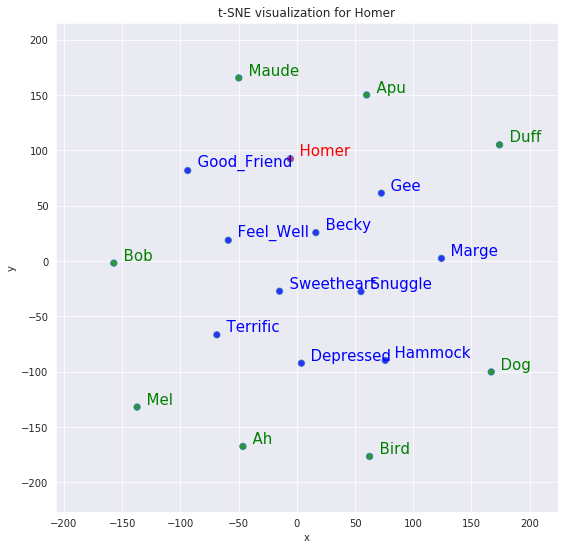

In [24]:
%matplotlib inline
tsnescatterplot(w2v_model, 'homer', 
                ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])